In [33]:
from quartic_sdk import APIClient
import pandas as pd
from sklearn.decomposition import PCA

In [34]:
# intialize a Quartic Platform API client
client = APIClient(host='https://qa.quartic.ai', 
                   username='Prathik', 
                   password='Prathik1')

# query asset
assets = client.assets()
asset = assets.get("name", "Asset Cont replay 01")

In [35]:
from datetime import datetime
from pytz import timezone

stop_time = int(datetime.now().timestamp() * 1000) # get current time in millisec unix timestamp
start_time = stop_time - 30 * 60 * 1000 # timestamp 30 mins ago

# fetch chuncks of DataFrames and then concatenate them into a piece
asset_data_itr = asset.data(start_time=start_time, stop_time=stop_time)
df = pd.DataFrame()
for next_df in asset_data_itr:
    df = pd.concat([df, next_df])
    
df

,39552,39553,39554,39555,39556,39557,39558,39559,39560,39561,...,40046,39543,39544,39545,39546,39547,39548,39549,39550,39551
1616615418000,120.487,11,11,9.9263,9.812700,716,35.176,40.973,38.363,30.566,...,10.545966,11,1941,11,46.485,2.121,2345.8200,7.976,10.139,146.51900
1616615419000,120.463,12,12,9.9299,9.815800,717,35.176,40.973,38.363,30.566,...,11.504274,12,1942,12,46.485,2.121,2345.8000,7.984,10.120,146.49600
1616615420000,120.571,13,13,9.9316,9.819201,718,35.176,40.973,38.363,30.566,...,12.462582,13,1943,13,46.485,2.121,2345.8000,7.756,10.138,146.54900
1616615421000,120.442,14,14,9.9278,9.814200,719,35.176,40.973,38.363,30.566,...,13.420889,14,1944,14,46.485,2.121,2345.7000,8.089,10.149,146.59900
1616615422000,120.509,15,15,9.9253,9.810300,720,35.176,40.973,38.363,30.566,...,14.379197,15,1945,15,46.485,2.121,2345.5200,7.965,10.152,146.67400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616617213000,NaN,3,3,9.9453,9.825800,2463,35.187,40.977,38.348,30.539,...,NaN,3,88,3,46.686,2.144,2949.4001,NaN,10.184,191.45900
1616617214000,NaN,4,4,9.9511,9.829000,2464,35.187,40.977,38.348,30.539,...,NaN,4,89,4,46.686,2.144,2947.9200,0.001,10.182,191.46300
1616617215000,NaN,5,5,9.9489,9.827300,2465,35.187,40.977,38.348,30.539,...,NaN,5,90,5,46.686,2.144,2948.0000,0.001,10.166,191.46600
1616617216000,NaN,6,6,9.9557,9.830000,2466,35.094,40.891,38.359,30.523,...,NaN,6,91,6,46.522,2.133,2949.4800,0.001,10.169,191.45801


In [36]:
target_col = "39543"
feature_cols = ["39553", "39554", "39555", "39556", "39557", "39558"]
df_X = df[feature_cols]
df_y = df[[target_col]]
y = df_y.to_numpy()

In [37]:
class DataframeFunctionTransformer():
    def __init__(self):
        self.func = self.process_df

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def max_value_of_last_hour(row):
        end_ts = row.name
        start_ts = end_ts - 60 * 60 * 1000  # last hour
        # Take the max values between row timestamp t and t - 1 hour
        row = df_X[(df_X.index >= start_ts) & (df_X.index <= end_ts)].max()
        row = row.rename(end_ts)
        return row

    @classmethod
    def process_df(cls, df):
        return df.apply(cls.max_value_of_last_hour, axis=1)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define a pipeline which contains three steps
pipe = Pipeline([
    ('max_of_last_hour', DataframeFunctionTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=123))
]).fit(df_X)

X_pca = pipe.transform(df_X)

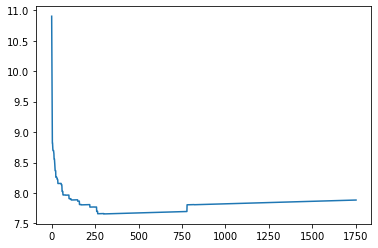

In [39]:
# apply processed data to a linear reg model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_pca, y)
preds = reg.predict(X_pca)
res = preds.flatten()

import matplotlib.pyplot as plt
plt.plot(res)

In [40]:
from quartic_sdk.model import BaseQuarticModel

class LinearRegressionModel(BaseQuarticModel):
    def __init__(self, name, description, log_level, model, pipe):
        self.model = model
        self.pipe = pipe
        super().__init__(name=name, description=description, log_level=log_level)
        
    def predict(self, input_df: pd.DataFrame):
        self.log.info("Predicting...")
        X_pca = self.pipe.transform(input_df)
        y_preds = self.model.predict(X_pca)
        return pd.Series(y_preds.flatten())

lr_pca_model = LinearRegressionModel(name="lr_by_pipe",
                                     description="model trained with pipeline",
                                     log_level="INFO",
                                     model=reg,
                                     pipe=pipe)

lr_pca_model.save(client=client, 
                  output_tag_name='lr_by_pipe', 
                  feature_tags=feature_cols, 
                  target_tag=target_col, 
                  test_df=df_X)

Exception: Failed to Save model: {"code":400,"message":"A model with name \"lr_by_pipe\" already exists, try different model name"}